# Comparison of Categorical Variable Encoding Methods

<p class="summary">Introduction of OneHot Encoding and other categorical variable encoding methods and performance evaluation using actual data</p>

## Overview

Speaking of encoding methods of categorical variable, OneHot Encoding is famous, but there are various other methods.  
In this tutorial we introduce some encoding methods for categorical variables and apply them to actual data.  
Then, we train the neural network model with the applied data and verify the change of metrics by preprocessing methods. 

## Required Libraries

ReNom==2.6
category-encoders==1.2.8  
matplotlib==2.1.2  
numpy==1.14.5  
pandas==0.22.0  
scikit-learn==0.19.1  
seaborn==0.8.1  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.simplefilter(action='ignore')

import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import renom as rm
from renom.optimizer import Sgd, Adam
# from renom.cuda import set_cuda_active

from sklearn.metrics import confusion_matrix, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(1234)

# set_cuda_active(False)

%matplotlib inline

## Dataset

Solve the classification problem using ["adult dataset"](https://archive.ics.uci.edu/ml/datasets/adult).  
This dataset is census data and contains feature values of each person's attributes such as sex and age, and the label whether income exceeds $50K/yr.  
This dataset, problem settings, models and learning methods are based on ["Annual Income Classification"](http://www.renom.jp/notebooks/clustering/annual-income-classification/notebook.html)

## Import and preprocess data

In [2]:
def make_col_names():
    """
    Extract column names from data description.
    """
    col_names = []
    for i, line in enumerate(open('../input/adult/adult.names', 'r')):
        # column names other than "annual income" are written on the left end after line 96.
        if i >= 96:
            col_name = line.split(":")[0]
            col_names.append(col_name)
    col_names.append('annual-income')
    
    return col_names

In [3]:
def load_data(path, col_names, is_data_train=True):
    # First line of test data is unnecessary.
    skiprows = 0 if is_data_train else 1
    df = pd.read_csv(path, header=None, encoding='utf-8', skiprows=skiprows)
    df.columns = col_names
    
    # Display the number of records before delete missing values.
    print('the number of records before delete missing values: {}'.format(df.shape[0]))
    
    # Replace the missing value's character to np.nan.
    # Unify the different written forms.
    df.replace({' ?': np.nan, ' <=50K.': ' <=50K', ' >50K.': ' >50K'}, inplace=True)
    
    # Print the number of rows containing missing values per column.
    # Delete row that contains even one missing value.
    print('the number of missing values by column')
    print(df.isnull().sum())
    df.dropna(axis=0, inplace=True)
    
    # Display the  number of records after delete missing values.
    print('the number of records after delete missing values: {}'.format(df.shape[0]))
    return df

In [4]:
col_names = make_col_names()

In [5]:
train = load_data('../input/adult/adult.data', col_names, is_data_train=True)
print('')
test = load_data('../input/adult/adult.test', col_names, is_data_train=False)

the number of records before delete missing values: 32561
the number of missing values by column
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
annual-income        0
dtype: int64
the number of records after delete missing values: 30162

the number of records before delete missing values: 16281
the number of missing values by column
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
annual-income       0
dtype: int64
the number of records after delete missing valu

In [6]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Encoding of categorical variables

Try some encoding methods for categorical variables.

### Overview of encoding method

We try to apply 4 encoding methods.

* Encoding method to increase the number of columns
    * OneHot Encoding
    * Hash Encoding
* Encoding methos not to increase the number of columns
    * Ordinal Encoding
    * Target Encoding
    
Details of each method will be described later.  
We use [Category Encoder](http://contrib.scikit-learn.org/categorical-encoding/index.html) library to encode categorical variables.

### Overview of categorical variables

Get categorical variable from dataset.

In [7]:
# get list of categorical columns
categorical_columns = [c for c in train.columns if (train[c].dtype == 'object')&(c != 'annual-income')]

The names and number of items of each categorical variable are as follows.

In [8]:
for col in categorical_columns:
    print('column name: {}'.format(col))
    print('number of items: {}'.format(train[col].nunique()))
    print('')

column name: workclass
number of items: 7

column name: education
number of items: 16

column name: marital-status
number of items: 7

column name: occupation
number of items: 14

column name: relationship
number of items: 6

column name: race
number of items: 5

column name: sex
number of items: 2

column name: native-country
number of items: 41



### Encoding method which increase the number of columns

### OneHot Encoding

OneHot Encoding creates a new column for each category, each variable, and each item, 1 if the value of the category variables is that item, and 0 if not.  
There is a dedicated tutorial for ["Onehot Conversion for Categorical Data"](http://www.renom.jp/notebooks/preprocessing/onehot/notebook.html)

<img src='renom_cat_onehot.png'>

In [9]:
ohe = ce.OneHotEncoder(cols=categorical_columns, handle_unknown='ignore') # handle_unknown: fit譎ゅ↓蟄伜惠縺励↑縺九▲縺滄��岼繧偵←縺�桶縺�°縲∽ｻ雁屓縺ｯ辟｡隕悶☆繧欺ntrain_ohe = ohe.fit_transform(train)
test_ohe = ohe.transform(test)

Make sure that the categorical variable is encoded or check the "workclass" column as an example.

In [10]:
display(pd.concat([train['workclass'].rename('workclass_before'), train_ohe.filter(regex=r'workclass')], axis=1).head())

,workclass_before,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,State-gov,1,0,0,0,0,0,0
1,Self-emp-not-inc,0,1,0,0,0,0,0
2,Private,0,0,1,0,0,0,0
3,Private,0,0,1,0,0,0,0
4,Private,0,0,1,0,0,0,0


The leftmost column is before encoding, the right columns are after encoding.  
You can see that OneHot Encoding is applied.  
If you want to know which item of which column was converted to which column, you can create a correspondence table.

In [11]:
def get_ordinal_mapping(encoding_instance):
    map_list = []
    for col in encoding_instance.category_mapping:
        for (label, ord_num) in col['mapping']:
            map_list.append([col['col'], label, ord_num])
    map_df = pd.DataFrame(map_list, columns=['column', 'label', 'ord_num'])
    return map_df

In [12]:
get_ordinal_mapping(ohe).head(10)

,column,label,ord_num
0,workclass,State-gov,1
1,workclass,Self-emp-not-inc,2
2,workclass,Private,3
3,workclass,Federal-gov,4
4,workclass,Local-gov,5
5,workclass,Self-emp-inc,6
6,workclass,Without-pay,7
7,education,Bachelors,1
8,education,HS-grad,2
9,education,11th,3


### Hash Encoding

Hash Encoding generates an arbitrary number of integer columns from all the specified categorical variables, using the hash function

<img src='renom_cat_hash.png'>

In the above figure, 2 rows of categorical variables are converted to 4 integer columns through the hash function.  
First create a zero vector of four columns. (Vector at the lower left of the upper figure)  
Next, we extract all values of category variables for each individual. ("State-gov", "Male" in the above figure)  
And do the following work for all extracted values.  
* Hash the value, convert it to an integer, and divide it by 4 (the number of columns) to find the remainder. (In the above figure, "State-gov" is hashed and the remainder is 2)  
* Add 1 to the corresponding column of the vector. (1 is added to "col_2" in the above figure)

In [13]:
# n_components=8 means HashingEncoder peform 8-digit hasing
he = ce.HashingEncoder(cols=categorical_columns, n_components=8)
train_he = he.fit_transform(train)
test_he = he.transform(test)

In [14]:
print('Before Hash Encoding')
display(train.head())
print('After Hash Encoding')
display(train_he.head())

Before Hash Encoding


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


After Hash Encoding


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,annual-income
0,1,1,2,0,0,2,2,0,39,77516,13,2174,0,40,<=50K
1,1,1,1,1,1,1,2,0,50,83311,13,0,0,13,<=50K
2,1,1,0,1,2,0,2,1,38,215646,9,0,0,40,<=50K
3,2,2,0,1,1,0,1,1,53,234721,7,0,0,40,<=50K
4,1,1,2,1,0,0,2,1,28,338409,13,0,0,40,<=50K


Comparing before and after Hash Encoding, you can see that there are no categorical variables and instead 8 columns, 'col_(number)' are are created.

### Encoding method without increasing the number of columns

### Ordinal Encoding

Ordinal Encoding creates a column in which serial numbers are assigned corresponding to the number of items in the categorical variable.

<img src='renom_cat_ordinal.png'>

In [15]:
oe = ce.OrdinalEncoder(cols=categorical_columns, handle_unknown='ignore')
train_oe = oe.fit_transform(train)
test_oe = oe.transform(test)

In [16]:
pd.concat([train['workclass'].rename('workclsss_before'), train_oe['workclass'].rename('workclass_after')], axis=1).head()

,workclsss_before,workclass_after
0,State-gov,1
1,Self-emp-not-inc,2
2,Private,3
3,Private,3
4,Private,3


You can see that serial numbers were given.

In [17]:
get_ordinal_mapping(oe).head(10)

,column,label,ord_num
0,workclass,State-gov,1
1,workclass,Self-emp-not-inc,2
2,workclass,Private,3
3,workclass,Federal-gov,4
4,workclass,Local-gov,5
5,workclass,Self-emp-inc,6
6,workclass,Without-pay,7
7,education,Bachelors,1
8,education,HS-grad,2
9,education,11th,3


### Target Encoding

Target Encoding calculates the average of target values for each categorical variable item and substitutes the categorical variable item using that value.  
In this tutorial, the annual income, which is the objective variable, is 1 for "over 50,000 dollars" and 0 for "less than 50,000 dollars".

<img src='renom_cat_target.png'>

In [18]:
train['annual-income'].unique() # unique items of "annual-income"

array([' <=50K', ' >50K'], dtype=object)

In [19]:
oe_target = ce.OrdinalEncoder(cols=['annual-income'], mapping=[{'col': 'annual-income', 'mapping': [(' <=50K', 0), (' >50K', 1)]}], handle_unknown='ignore')
train_target = oe_target.fit_transform(train[['annual-income']])

In [20]:
te = ce.TargetEncoder(cols=categorical_columns, handle_unknown='ignore')
train_te = te.fit_transform(train, train_target['annual-income']) # annual income > 50k
test_te = te.transform(test)

In [21]:
pd.concat([train['workclass'].rename('workclass_before'), train_te['workclass'].rename('workclass_after')], axis=1).head()

,workclass_before,workclass_after
0,State-gov,0.268960
1,Self-emp-not-inc,0.285714
2,Private,0.218792
3,Private,0.218792
4,Private,0.218792


In [22]:
def get_ordinal_mapping_te(encoding_instance):
    map_list = []
    for col in encoding_instance.mapping:
        for (label, statistics) in col['mapping'].items():
            map_list.append([col['col'], label, statistics['mean']])
    map_df = pd.DataFrame(map_list, columns=['column', 'label', 'mean'])
    return map_df

In [23]:
get_ordinal_mapping_te(te).head(10)

,column,label,mean
0,workclass,Federal-gov,0.387063
1,workclass,Local-gov,0.294630
2,workclass,Private,0.218792
3,workclass,Self-emp-inc,0.558659
4,workclass,Self-emp-not-inc,0.285714
5,workclass,State-gov,0.268960
6,workclass,Without-pay,0.000000
7,education,10th,0.071951
8,education,11th,0.056298
9,education,12th,0.076923


Looking at the correspondence table above, for example, "Self-emp-inc" accounts for about 56% of annual income exceeding $ 50,000.

## Data processing for input to the model

In order to train the machine learning model, it is necessary to convert the data from pd.DataFrame to np.array.  
In this tutorial, we are working on a binary classification problem of "classifying as to whether the annual income y of that person is more than 50,000 dollars or less when giving a person's features X of m columns".  
Therefore, train and test dataset is processed as follows.  

X: np.array of n rows, m columns(n: the number of data, m: the number of features)  
y: np.array of n rows, 2 columns(n: the number of data, 2: types of correct label)

## Processing of feature variables

Drop the target variable from the original data and extract np.array

In [24]:
X_train_ohe = train_ohe.drop(['annual-income'], axis=1).values
X_test_ohe = test_ohe.drop(['annual-income'], axis=1).values

X_train_he = train_he.drop(['annual-income'], axis=1).values
X_test_he = test_he.drop(['annual-income'], axis=1).values

X_train_oe = train_oe.drop(['annual-income'], axis=1).values
X_test_oe = test_oe.drop(['annual-income'], axis=1).values

X_train_te = train_te.drop(['annual-income'], axis=1).values
X_test_te = test_te.drop(['annual-income'], axis=1).values

In the neural network model, it works better when the measure of feature quantity is the same.  
In the ["Normalization and standardization"](http://www.renom.jp/notebooks/tutorial/preprocessing/normalization/notebook.html) tutorial, we introduced the improvement of learning speed using standardization, but we can expect the effect of improving the prediction accuracy of the model.  
Although we will not go deeply in this tutorial, it is a good idea to compare the accuracy with and without normalization or standardization.  
We will normalize this time.

In [25]:
mms = MinMaxScaler()
X_train_ohe_mms = mms.fit_transform(X_train_ohe)
X_test_ohe_mms = mms.transform(X_test_ohe)

X_train_he_mms = mms.fit_transform(X_train_he)
X_test_he_mms = mms.transform(X_test_he)

X_train_oe_mms = mms.fit_transform(X_train_oe)
X_test_oe_mms = mms.transform(X_test_oe)

X_train_te_mms = mms.fit_transform(X_train_te)
X_test_te_mms = mms.transform(X_test_te)

## Processing of target variables

Since the assignment of this time is a binary classification, we divide the objective variable of one column into two columns.  
Increase it to 2 columns with OneHot Encoding and extract np.array.

In [26]:
ohe_target = ce.OneHotEncoder(cols=['annual-income'], handle_unknown='ignore')
y_train = ohe_target.fit_transform(train[['annual-income']]).values
y_test = ohe_target.transform(test[['annual-income']]).values

In [27]:
get_ordinal_mapping(ohe_target)

,column,label,ord_num
0,annual-income,<=50K,1
1,annual-income,>50K,2


In [28]:
pd.concat([train['annual-income'].rename('annual-income_before'), ohe_target.fit_transform(train[['annual-income']])], axis=1).head(10)

,annual-income_before,annual-income_1,annual-income_2
0,<=50K,1,0
1,<=50K,1,0
2,<=50K,1,0
3,<=50K,1,0
4,<=50K,1,0
5,<=50K,1,0
6,<=50K,1,0
7,>50K,0,1
8,>50K,0,1
9,>50K,0,1


The leftmost column is encoded in the middle and right two columns.  
The center and right two columns converted to np.array will be y_train.  

In [29]:
y_train[:10, :]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1]])

Finally, check the form of the data to enter.

In [30]:
print('Features')
print('OneHot Encoding: {}rows, {}columns'.format(X_train_ohe_mms.shape[0], X_train_ohe_mms.shape[1]))
print('Hash Encoding     : {}rows, {}columns'.format(X_train_he_mms.shape[0], X_train_he_mms.shape[1]))
print('Ordinal Encoding : {}rows, {}columns'.format(X_train_oe_mms.shape[0], X_train_oe_mms.shape[1]))
print('Target Encoding : {}rows, {}columns'.format(X_train_te_mms.shape[0], X_train_te_mms.shape[1]))
print('')
print('Target: {}rows, {}columns'.format(y_train.shape[0], y_train.shape[1]))

Features
OneHot Encoding: 30162rows, 104columns
Hash Encoding     : 30162rows, 14columns
Ordinal Encoding : 30162rows, 14columns
Target Encoding : 30162rows, 14columns

Target: 30162rows, 2columns


## Model definition

We define a model of a multi perceptron with two layers of hidden layers.  
Make the output layer 2 columns according to y_train.  

In [31]:
sequential = rm.Sequential([
    rm.Dense(128),
    rm.Relu(),
    rm.Dense(64),
    rm.Relu(),
    rm.Dense(2)
])

## Setting parameters

In [32]:
epochs = 1000
batch_size= 128
period = 10 # early stopping

Early stopping is a technique for preventing overfitting and finding the optimum epochs.  
In fitting, if test loss does not decrease with a certain number of epochs, learning is interrupted there.

## Fitting

Give data made by different category encoding methods to the defined model and verify accuracy.

In [33]:
def fit(sequential, X_train, y_train, X_test, y_test, epochs=500, batch_size=128, early_stopping=None):
    # early stopping
    if early_stopping is not None:
        es_cnt = 0
        es_max = early_stopping
        es_loss = np.inf
    
    # learning curve
    train_learning_curve = []
    test_learning_curve = []
    
    # data size
    N = len(X_train)
    
    # optimizer
    optimizer = Adam(lr=0.00005)
    
    for i in range(epochs):
        # batch processing
        perm = np.random.permutation(N)
        loss = 0
        for j in range(0, N // batch_size):
            train_batch = X_train[perm[j*batch_size : (j+1)*batch_size]]
            response_batch = y_train[perm[j*batch_size : (j + 1)*batch_size]]
            
            with sequential.train():
                l = rm.softmax_cross_entropy(sequential(train_batch), response_batch)
            grad = l.grad()
            grad.update(optimizer)
            loss += l.as_ndarray()
            
            sequential.save('../weight/epoch{}_weight.h5'.format(i))
        
        #  calculate test_loss
        test_loss = rm.softmax_cross_entropy(sequential(X_test), y_test).as_ndarray()
        
        # contain train_loss and test_loss
        loss = loss / (N // batch_size)
        train_learning_curve.append(loss)
        test_learning_curve.append(test_loss)
        
        # early stopping
        if early_stopping is not None:
            if test_loss < es_loss:
                es_loss = test_loss
                es_cnt = 0
            else:
                es_cnt += 1
            
            if es_cnt >= es_max:
                break
        
        # print train_loss and test_loss
        if i % 50 == 0:
            print('epoch: {:03d}, train_loss:{:.4f},  test_loss:{:.4f}'.format(i, float(loss), float(test_loss)))
    # contain best iteration
    if early_stopping is not None:
        best_iter = i - (early_stopping + 1)
        best_train_loss = train_learning_curve[-early_stopping-1]
        best_test_loss = test_learning_curve[-early_stopping-1]
    else:
        best_iter = i
        best_train_loss = loss
        best_test_loss = test_loss
    
    print('All done!')
    print('Best iteration: {:03d}, Train loss: {:.4f}, Test loss: {:.4f}'.format(best_iter, best_train_loss, best_test_loss))
    
    return train_learning_curve, test_learning_curve

In [34]:
def plot_learning_curve(train_learning_curve, test_learning_curve, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        
    ax.plot(train_learning_curve, linewidth=1, label='train')
    ax.plot(test_learning_curve, linewidth=1, label='test')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error')
    ax.legend()
    if ax is None:
        plt.show()
    else:
        return ax

### OneHot Encoding

In [35]:
train_learning_curve, test_learning_curve = fit(sequential, X_train_ohe_mms, y_train, X_test_ohe_mms, y_test, epochs, batch_size, period)

epoch: 000, train_loss:0.5263,  test_loss:0.4593
epoch: 050, train_loss:0.3108,  test_loss:0.3286
All done!
Best iteration: 059, Train loss: 0.3067, Test loss: 0.3280


In [36]:
best_test_loss_ohe = test_learning_curve[-(period+1)]

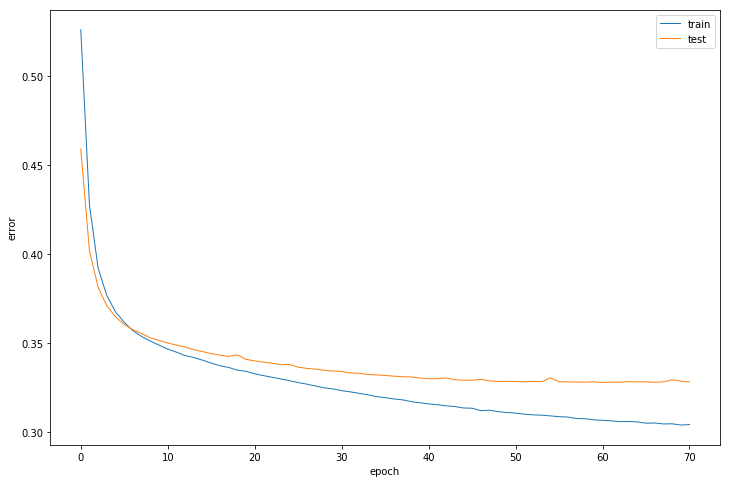

In [37]:
plot_learning_curve(train_learning_curve, test_learning_curve)

Reset model weight once to verify with multiple data.  
For details, refer to ["Saving and Loading Models"](http://www.renom.jp/notebooks/product/renom_dl/save-model/notebook.html).

In [38]:
# reset weight params
for layer in sequential.iter_models():
    setattr(layer, 'params', {})

### Hash Encoding

In [39]:
train_learning_curve, test_learning_curve = fit(sequential, X_train_he_mms, y_train, X_test_he_mms, y_test, epochs, batch_size, period)

epoch: 000, train_loss:0.6348,  test_loss:0.5710
epoch: 050, train_loss:0.3482,  test_loss:0.3548
epoch: 100, train_loss:0.3420,  test_loss:0.3504
epoch: 150, train_loss:0.3393,  test_loss:0.3491
epoch: 200, train_loss:0.3373,  test_loss:0.3485
epoch: 250, train_loss:0.3351,  test_loss:0.3478
epoch: 300, train_loss:0.3339,  test_loss:0.3470
All done!
Best iteration: 319, Train loss: 0.3330, Test loss: 0.3468


In [40]:
best_test_loss_he = test_learning_curve[-(period+1)]

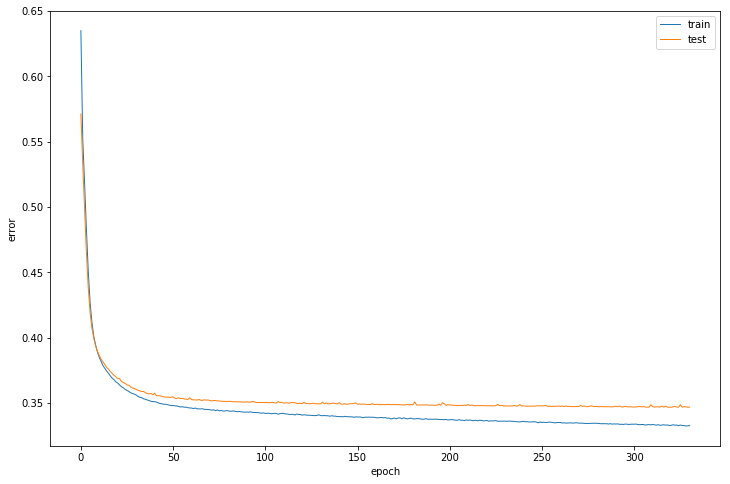

In [41]:
plot_learning_curve(train_learning_curve, test_learning_curve)

In [42]:
# reset weight params
for layer in sequential.iter_models():
    setattr(layer, 'params', {})

### Ordinal Encoding

In [43]:
train_learning_curve, test_learning_curve = fit(sequential, X_train_oe_mms, y_train, X_test_oe_mms, y_test, epochs, batch_size, period)

epoch: 000, train_loss:0.6215,  test_loss:0.5616
epoch: 050, train_loss:0.3331,  test_loss:0.3351
epoch: 100, train_loss:0.3265,  test_loss:0.3313
epoch: 150, train_loss:0.3232,  test_loss:0.3302
epoch: 200, train_loss:0.3205,  test_loss:0.3290
epoch: 250, train_loss:0.3185,  test_loss:0.3285
All done!
Best iteration: 240, Train loss: 0.3188, Test loss: 0.3285


In [44]:
best_test_loss_oe = test_learning_curve[-(period+1)]

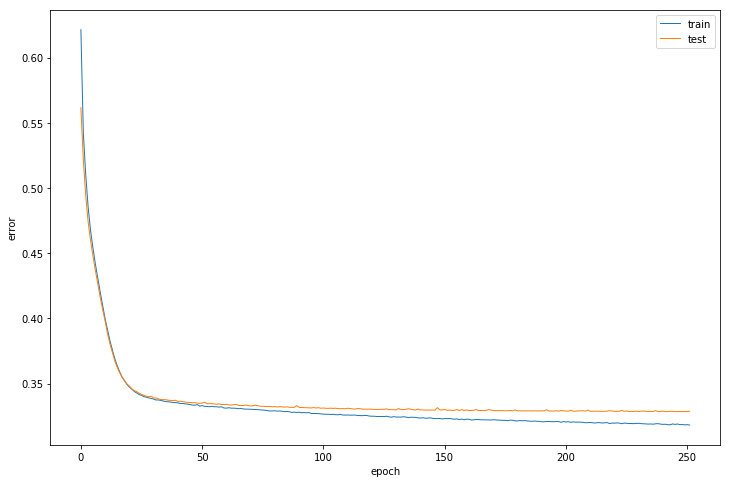

In [45]:
plot_learning_curve(train_learning_curve, test_learning_curve)

In [46]:
# reset weight params
for layer in sequential.iter_models():
    setattr(layer, 'params', {})

### Target Encoding

In [47]:
train_learning_curve, test_learning_curve = fit(sequential, X_train_te_mms, y_train, X_test_te_mms, y_test, epochs, batch_size, period)

epoch: 000, train_loss:0.5612,  test_loss:0.5060
epoch: 050, train_loss:0.3219,  test_loss:0.3256
epoch: 100, train_loss:0.3176,  test_loss:0.3225
epoch: 150, train_loss:0.3155,  test_loss:0.3213
All done!
Best iteration: 171, Train loss: 0.3153, Test loss: 0.3206


In [48]:
best_test_loss_te = test_learning_curve[-(period+1)]

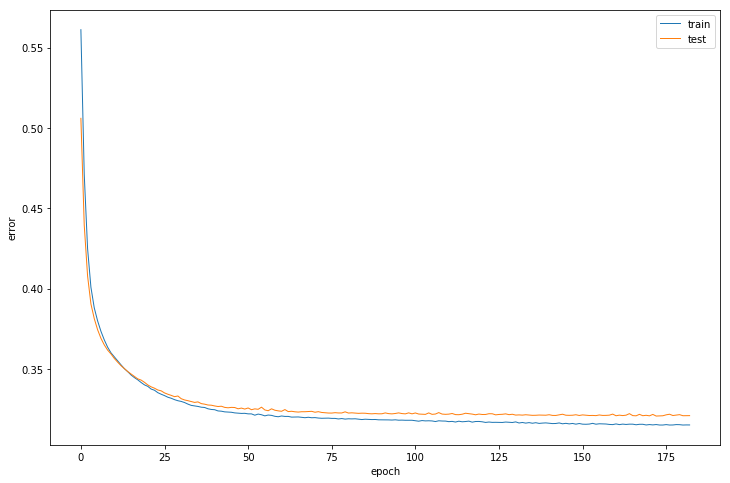

In [49]:
plot_learning_curve(train_learning_curve, test_learning_curve)

In [50]:
# reset weight params
for layer in sequential.iter_models():
    setattr(layer, 'params', {})

## Result

Comparing the test loss by encoding of four categorical variables, it became as follows.

In [51]:
print('OneHot Encoding: {:.4f}'.format(best_test_loss_ohe))
print('Hash Encoding: {:.4f}'.format(best_test_loss_he))
print('Ordinal Encoding: {:.4f}'.format(best_test_loss_oe))
print('Target Encoding: {:.4f}'.format(best_test_loss_te))

OneHot Encoding: 0.3280
Hash Encoding: 0.3468
Ordinal Encoding: 0.3285
Target Encoding: 0.3206


## Conclusion

The accuracy of Target Encoding was the highest in this experiment.  
Since OneHot Encoding increases the dimension by the number of items in the category, it is possible to create complicated classification boundary planes, but the vectors become sparse, learning may becomes unstable.  
Therefore, Target Encoding, which is an encoding method that does not increase the number of columns, seems to be more accurate.  
If OneHot Encoding is used for category variables with a large number of items, it may be better to combine PCA or Embedding to reduce dimension.  
Reference) [Application of Entity Embedding Layer
](http://www.renom.jp/notebooks/tutorial/embedding/entity_embedding/notebook.html)